
# ViT-Style Deblur for Bolus Detection

Deblur frame $t+1$ toward frame $t$ (background restoration), then treat reconstruction error as motion/bolus evidence. Toggle masking the bolus out of the deblur loss to focus on background. Baseline bolus masks come from error thresholding; an optional lightweight fusion head can refine masks.


In [1]:

from pathlib import Path
from contextlib import nullcontext
import re
import random
from collections import defaultdict
import numpy as np
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Paths / data
DATA_ROOT = Path('.')
IMAGES_DIR = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'masks'

# Training/eval config
SEED = 42
TRAIN_FRACTION = 0.7
VAL_FRACTION = 0.15  # rest goes to test
MAX_TRAIN_PAIRS = 2000  # set None to use all
MAX_VAL_PAIRS = 400
MAX_TEST_PAIRS = 400

# Deblur model hyperparams
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
NUM_WORKERS = 0  # set >0 if spawn works in your setup
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
AUGMENT_TRAIN = True
USE_AMP = True
MASK_OUT_BOLUS_IN_LOSS = True  # if True, ignore bolus pixels when fitting deblur
BASE_FILTERS = (32, 64, 128)   # encoder widths for the small U-Net

# Bolus detection from error
ERROR_PERCENTILE = 99.5  # percentile threshold on error map per frame
USE_FUSE_HEAD = True     # learn a tiny conv head over [error, frame_t]
FUSE_EPOCHS = 3
FUSE_LR = 5e-3

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
amp_enabled = USE_AMP and device.type in {'cuda', 'mps'}
pin_memory = device.type == 'cuda'
persistent_workers = NUM_WORKERS > 0 and NUM_WORKERS is not None
print(f"Device: {device} | amp: {amp_enabled} | workers: {NUM_WORKERS}")


Device: mps | amp: True | workers: 0


In [2]:

FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)")


def parse_sequence_key(path: Path):
    m = FILENAME_PATTERN.match(path.stem)
    if not m:
        return None, None
    return m.group('prefix'), int(m.group('frame'))


def build_pairs(images_dir: Path, masks_dir: Path):
    grouped = defaultdict(list)
    for img_path in images_dir.glob('*.png'):
        prefix, frame_idx = parse_sequence_key(img_path)
        if prefix is None:
            continue
        grouped[prefix].append((frame_idx, img_path))

    pairs = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for (idx_a, path_a), (idx_b, path_b) in zip(frames, frames[1:]):
            mask_a = masks_dir / path_a.name
            if not mask_a.exists():
                continue
            pairs.append(dict(prefix=prefix, frame_a=idx_a, path_a=path_a, path_b=path_b, mask_a=mask_a))
    return pairs

pairs = build_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Total usable pairs (frame t, frame t+1 with mask_t): {len(pairs)}")

# Split by sequence to avoid leakage
seqs = sorted({p['prefix'] for p in pairs})
random.shuffle(seqs)
train_cut = int(len(seqs) * TRAIN_FRACTION)
val_cut = int(len(seqs) * (TRAIN_FRACTION + VAL_FRACTION))
train_seq = set(seqs[:train_cut])
val_seq = set(seqs[train_cut:val_cut])
test_seq = set(seqs[val_cut:])

def filter_pairs(seq_set, limit=None):
    out = [p for p in pairs if p['prefix'] in seq_set]
    if limit is not None:
        out = out[:limit]
    return out

train_pairs = filter_pairs(train_seq, MAX_TRAIN_PAIRS)
val_pairs = filter_pairs(val_seq, MAX_VAL_PAIRS)
test_pairs = filter_pairs(test_seq, MAX_TEST_PAIRS)
print(f"Train/Val/Test sizes: {len(train_pairs)}/{len(val_pairs)}/{len(test_pairs)} sequences: {len(train_seq)}/{len(val_seq)}/{len(test_seq)}")


Total usable pairs (frame t, frame t+1 with mask_t): 6337
Train/Val/Test sizes: 2000/400/400 sequences: 60/13/14


In [3]:

class FramePairDataset(Dataset):
    def __init__(self, pairs, augment=False, mask_loss=False):
        self.pairs = pairs
        self.augment = augment
        self.mask_loss = mask_loss

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        info = self.pairs[idx]
        frame_t = cv2.imread(str(info['path_a']), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        frame_tp1 = cv2.imread(str(info['path_b']), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask_t = cv2.imread(str(info['mask_a']), cv2.IMREAD_GRAYSCALE)
        mask_t = (mask_t > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                frame_t = np.flip(frame_t, axis=1).copy()
                frame_tp1 = np.flip(frame_tp1, axis=1).copy()
                mask_t = np.flip(mask_t, axis=1).copy()
            if random.random() < 0.5:
                frame_t = np.flip(frame_t, axis=0).copy()
                frame_tp1 = np.flip(frame_tp1, axis=0).copy()
                mask_t = np.flip(mask_t, axis=0).copy()

        # loss weight: ignore bolus if mask_loss
        weight = 1.0 - mask_t if self.mask_loss else np.ones_like(mask_t)

        x = torch.from_numpy(frame_tp1).unsqueeze(0)  # input frame t+1
        y = torch.from_numpy(frame_t).unsqueeze(0)    # target frame t
        mask_t = torch.from_numpy(mask_t).unsqueeze(0)
        weight = torch.from_numpy(weight).unsqueeze(0)
        return x, y, mask_t, weight


def make_loaders():
    loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persistent_workers)
    data_loaders = {
        'train': DataLoader(FramePairDataset(train_pairs, augment=AUGMENT_TRAIN, mask_loss=MASK_OUT_BOLUS_IN_LOSS), batch_size=TRAIN_BATCH_SIZE, shuffle=True, **loader_kwargs),
        'val': DataLoader(FramePairDataset(val_pairs, augment=False, mask_loss=MASK_OUT_BOLUS_IN_LOSS), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
        'test': DataLoader(FramePairDataset(test_pairs, augment=False, mask_loss=False), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
    }
    x, y, m, w = next(iter(data_loaders['train']))
    print('Sample batch shapes: x', x.shape, 'y', y.shape, 'mask', m.shape)
    return data_loaders

data_loaders = make_loaders()


Sample batch shapes: x torch.Size([4, 1, 512, 512]) y torch.Size([4, 1, 512, 512]) mask torch.Size([4, 1, 512, 512])


In [4]:

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class SmallUNet(nn.Module):
    def __init__(self, channels):
        super().__init__()
        c1, c2, c3 = channels
        self.enc1 = ConvBlock(1, c1)
        self.enc2 = ConvBlock(c1, c2)
        self.enc3 = ConvBlock(c2, c3)

        self.pool = nn.MaxPool2d(2)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up3 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        self.dec2 = ConvBlock(c1 + c2, c1)
        self.dec1 = ConvBlock(c1 + c3, c1)
        self.out = nn.Conv2d(c1, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d2 = self.dec2(torch.cat([e1, self.up2(e2)], dim=1))
        d1 = self.dec1(torch.cat([d2, self.up3(e3)], dim=1))
        return self.out(d1)


class FuseHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(8, 1, 1)
        )
    def forward(self, x):
        return self.net(x)

model = SmallUNet(BASE_FILTERS).to(device)
fuse_head = FuseHead().to(device) if USE_FUSE_HEAD else None
print('Deblur params (M):', sum(p.numel() for p in model.parameters())/1e6)


Deblur params (M): 0.379329


In [ ]:

def masked_l1(pred, target, weight):
    return (torch.abs(pred - target) * weight).mean()

def autocast_ctx():
    return torch.autocast(device_type=device.type, dtype=torch.float16) if amp_enabled else nullcontext()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler(enabled=False)  # not used for MPS, kept for compatibility

best_val = float('inf')
train_history, val_history = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running = 0.0
    bar = tqdm(data_loaders['train'], desc=f"Epoch {epoch}/{NUM_EPOCHS} [train]", leave=False)
    for x, y, _, w in bar:
        x, y, w = x.to(device), y.to(device), w.to(device)
        optimizer.zero_grad()
        with autocast_ctx():
            pred = model(x)
            loss = masked_l1(pred, y, w)
        loss.backward()
        optimizer.step()
        running += loss.item() * x.size(0)
        bar.set_postfix(loss=loss.item())
    epoch_loss = running / len(data_loaders['train'].dataset)
    train_history.append(epoch_loss)

    model.eval()
    val_running = 0.0
    with torch.no_grad():
        bar = tqdm(data_loaders['val'], desc=f"Epoch {epoch}/{NUM_EPOCHS} [val]", leave=False)
        for x, y, _, w in bar:
            x, y, w = x.to(device), y.to(device), w.to(device)
            with autocast_ctx():
                pred = model(x)
                loss = masked_l1(pred, y, w)
            val_running += loss.item() * x.size(0)
            bar.set_postfix(loss=loss.item())
    val_loss = val_running / len(data_loaders['val'].dataset)
    val_history.append(val_loss)
    print(f"Epoch {epoch:02d} | train {epoch_loss:.4f} | val {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'vit_deblur_best.pt')
print('Best val loss:', best_val)


/var/folders/nf/g3zqj7192bn8hrrmps9bk9cr0000gn/T/ipykernel_983/2742004823.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=False)  # not used for MPS, kept for compatibility


Epoch 1/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 01 | train 0.0250 | val 0.0247


Epoch 2/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 02 | train 0.0197 | val 0.0560


Epoch 3/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 03 | train 0.0221 | val 0.0214


Epoch 4/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 04 | train 0.0227 | val 0.0360


Epoch 5/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 05 | train 0.0188 | val 0.0186


Epoch 6/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 06 | train 0.0167 | val 0.0139


Epoch 7/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 07 | train 0.0171 | val 0.0170


Epoch 8/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 08 | train 0.0235 | val 0.0138


Epoch 9/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 09 | train 0.0190 | val 0.0146


Epoch 10/10 [train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10 [val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10 | train 0.0181 | val 0.0762
Best val loss: 0.013789136316627265


In [ ]:

# Reload best model
if Path('vit_deblur_best.pt').exists():
    model.load_state_dict(torch.load('vit_deblur_best.pt', map_location=device))
model.eval()


def compute_metrics(pred_mask, gt_mask):
    pred = pred_mask.astype(bool)
    gt = gt_mask.astype(bool)
    inter = (pred & gt).sum()
    union = (pred | gt).sum()
    pred_sum = pred.sum()
    gt_sum = gt.sum()
    dice = 2 * inter / (pred_sum + gt_sum + 1e-6)
    iou = inter / (union + 1e-6)
    prec = inter / (pred_sum + 1e-6)
    rec = inter / (gt_sum + 1e-6)
    return dict(dice=dice, iou=iou, precision=prec, recall=rec)


def error_to_mask(err_map, percentile=99.5):
    thresh = np.percentile(err_map, percentile)
    return (err_map > thresh).astype(np.uint8)

# Collect predictions on test set
err_metrics = []
all_preds = []
all_gts = []
samples = []

with torch.no_grad():
    bar = tqdm(data_loaders['test'], desc='Test deblur/error', leave=False)
    for x, y, gt_mask, _ in bar:
        x, y = x.to(device), y.to(device)
        with autocast_ctx():
            pred = model(x)
        err = torch.abs(pred - y).cpu().numpy()
        for i in range(err.shape[0]):
            e = err[i,0]
            g = gt_mask[i,0].numpy().astype(np.uint8)
            m = error_to_mask(e, percentile=ERROR_PERCENTILE)
            metrics = compute_metrics(m, g)
            err_metrics.append(metrics)
            all_preds.append(m)
            all_gts.append(g)
            if len(samples) < 4:
                samples.append(dict(frame_t=y[i,0].cpu().numpy(), frame_tp1=x[i,0].cpu().numpy(), pred=pred[i,0].cpu().numpy(), err=e, gt=g, mask=m))

if err_metrics:
    agg = {k: float(np.mean([m[k] for m in err_metrics])) for k in err_metrics[0].keys()}
    print('Error-threshold bolus metrics:', agg)
else:
    print('No test samples')


Test deblur/error:   0%|          | 0/100 [00:00<?, ?it/s]

Error-threshold bolus metrics: {'dice': 0.0018511422691090728, 'iou': 0.0009442941518476092, 'precision': 0.002502161694540257, 'recall': 0.0025811002044564724}


In [7]:

if USE_FUSE_HEAD:
    fuse_optim = torch.optim.Adam(fuse_head.parameters(), lr=FUSE_LR)
    bce = nn.BCEWithLogitsLoss()
    fuse_head.train()
    for epoch in range(1, FUSE_EPOCHS + 1):
        running = 0.0
        bar = tqdm(data_loaders['train'], desc=f"Fuse head {epoch}/{FUSE_EPOCHS}", leave=False)
        for x, y, gt_mask, _ in bar:
            x, y, gt_mask = x.to(device), y.to(device), gt_mask.to(device)
            with autocast_ctx():
                with torch.no_grad():
                    pred = model(x)
                err = torch.abs(pred - y)
                inp = torch.cat([err, y], dim=1)
                logits = fuse_head(inp)
                loss = bce(logits, gt_mask)
            fuse_optim.zero_grad()
            loss.backward()
            fuse_optim.step()
            running += loss.item() * x.size(0)
            bar.set_postfix(loss=loss.item())
        print(f"Fuse head epoch {epoch}: loss {running/len(data_loaders['train'].dataset):.4f}")

    # Eval fuse head
    fuse_head.eval()
    fuse_metrics = []
    with torch.no_grad():
        bar = tqdm(data_loaders['test'], desc='Test fuse', leave=False)
        for x, y, gt_mask, _ in bar:
            x, y = x.to(device), y.to(device)
            gt_mask = gt_mask.to(device)
            with autocast_ctx():
                pred = model(x)
                err = torch.abs(pred - y)
                inp = torch.cat([err, y], dim=1)
                logits = fuse_head(inp)
                probs = torch.sigmoid(logits)
            mask = (probs > 0.5).float().cpu().numpy()
            gt = gt_mask.cpu().numpy()
            for m, g in zip(mask, gt):
                metrics = compute_metrics(m[0].astype(np.uint8), g[0].astype(np.uint8))
                fuse_metrics.append(metrics)
    if fuse_metrics:
        agg = {k: float(np.mean([m[k] for m in fuse_metrics])) for k in fuse_metrics[0].keys()}
        print('Fuse-head bolus metrics:', agg)


Fuse head 1/3:   0%|          | 0/500 [00:00<?, ?it/s]

Fuse head epoch 1: loss 0.0734


Fuse head 2/3:   0%|          | 0/500 [00:00<?, ?it/s]

Fuse head epoch 2: loss 0.0573


Fuse head 3/3:   0%|          | 0/500 [00:00<?, ?it/s]

Fuse head epoch 3: loss 0.2084


Test fuse:   0%|          | 0/100 [00:00<?, ?it/s]

Fuse-head bolus metrics: {'dice': 0.0, 'iou': 0.0, 'precision': 0.0, 'recall': 0.0}


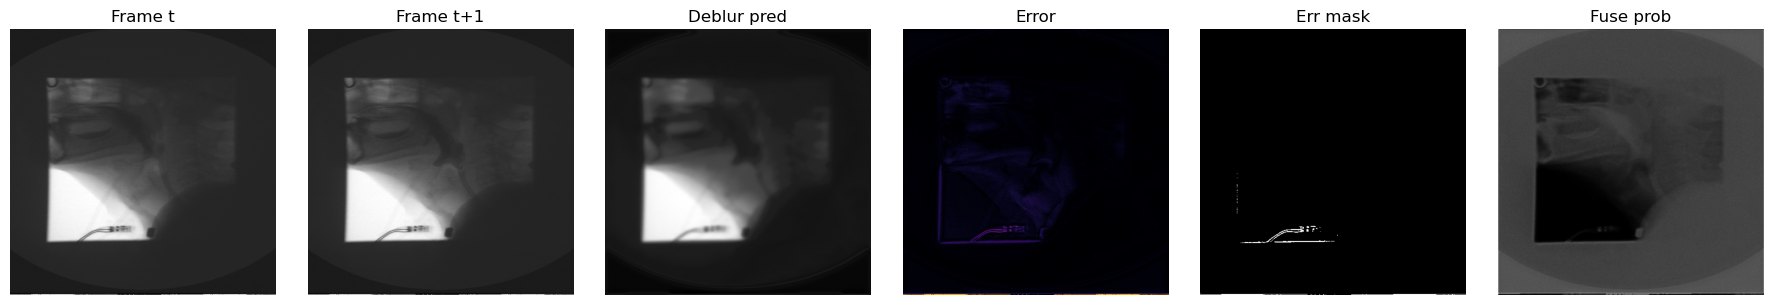

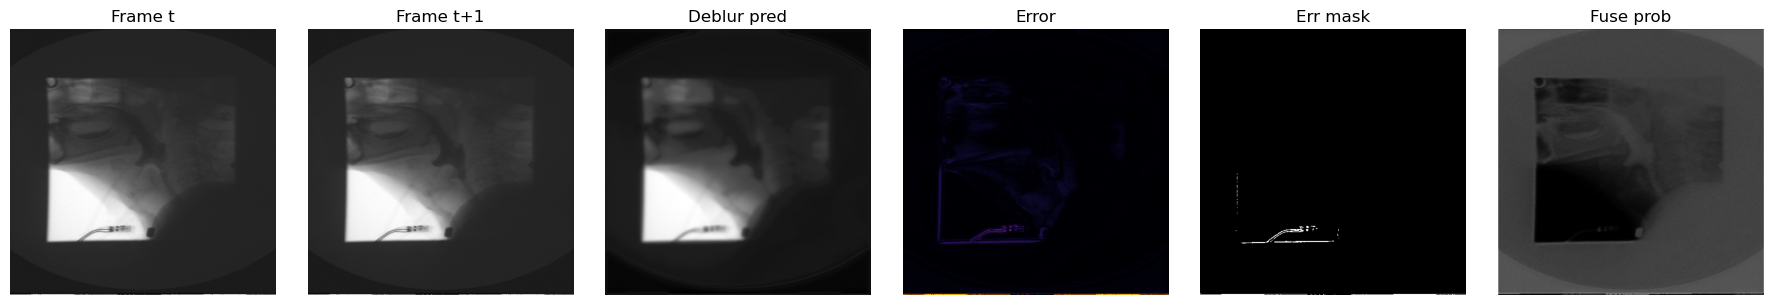

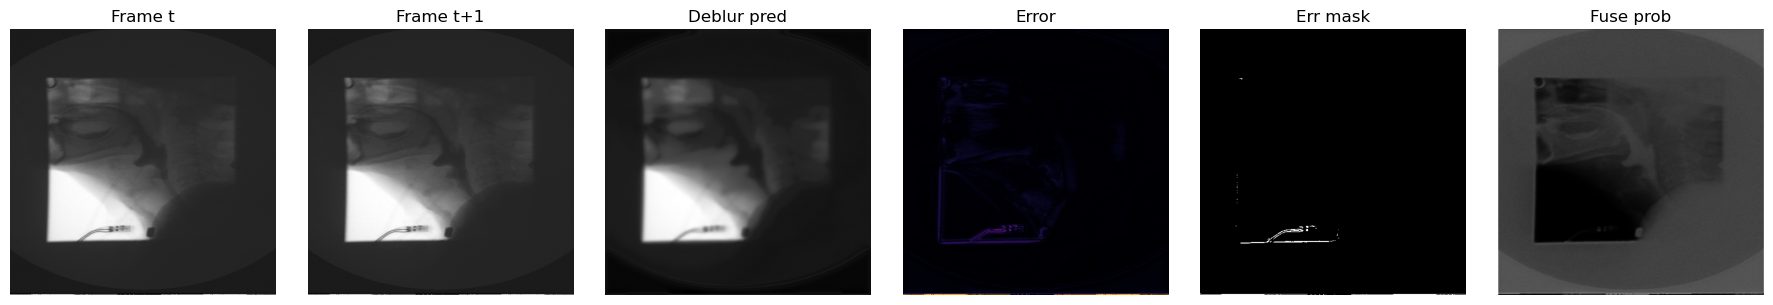

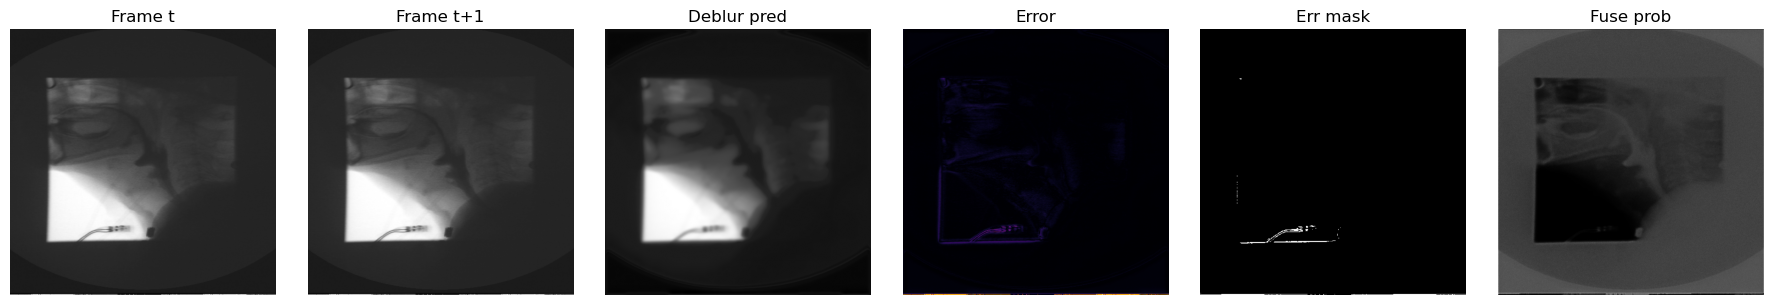

In [8]:

# Visualize a few samples
ncols = 6 if USE_FUSE_HEAD else 5
for idx, sample in enumerate(samples):
    fig, axs = plt.subplots(1, ncols, figsize=(3*ncols, 3))
    axs[0].imshow(sample['frame_t'], cmap='gray'); axs[0].set_title('Frame t'); axs[0].axis('off')
    axs[1].imshow(sample['frame_tp1'], cmap='gray'); axs[1].set_title('Frame t+1'); axs[1].axis('off')
    axs[2].imshow(sample['pred'], cmap='gray'); axs[2].set_title('Deblur pred'); axs[2].axis('off')
    axs[3].imshow(sample['err'], cmap='inferno'); axs[3].set_title('Error'); axs[3].axis('off')
    axs[4].imshow(sample['mask'], cmap='gray'); axs[4].set_title('Err mask'); axs[4].axis('off')
    if USE_FUSE_HEAD:
        x = torch.from_numpy(sample['frame_tp1']).unsqueeze(0).unsqueeze(0).to(device)
        y = torch.from_numpy(sample['frame_t']).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            with autocast_ctx():
                pred = model(x)
                err = torch.abs(pred - y)
                inp = torch.cat([err, y], dim=1)
                logits = fuse_head(inp)
                fuse = torch.sigmoid(logits)[0,0].cpu().numpy()
        axs[5].imshow(fuse, cmap='gray'); axs[5].set_title('Fuse prob'); axs[5].axis('off')
    plt.tight_layout()
    plt.show()
